In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image

# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  6352


In [18]:
# Root directory for dataset
#dataroot = "C:/Users/yyhh/Desktop/Morpheus/data/celeba"
dataroot = "data/HTile128"
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               #transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),

                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               #transforms.Normalize((0.5,), (0.5,)),

                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
#print(len(dataloader))
#print(dataloader)
#nextitem= next(iter(dataloader))
#print(type(dataloader))
#print(type(next(iter(dataloader))))
#print(len(next(iter(dataloader))))
#print(nextitem)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print(torch.cuda.is_available())

# Plot some training images
real_batch = next(iter(dataloader))

print(type(real_batch))

#plt.figure(figsize=(8,8))
#plt.axis("off")
#plt.title("Training Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

True
<class 'list'>


In [5]:
real_batch = next(iter(dataloader))
print(type(real_batch))
print(type(real_batch[0]))
print(len(real_batch[0][0][0]))
#print(real_batch[0])


<class 'list'>
<class 'torch.Tensor'>
128


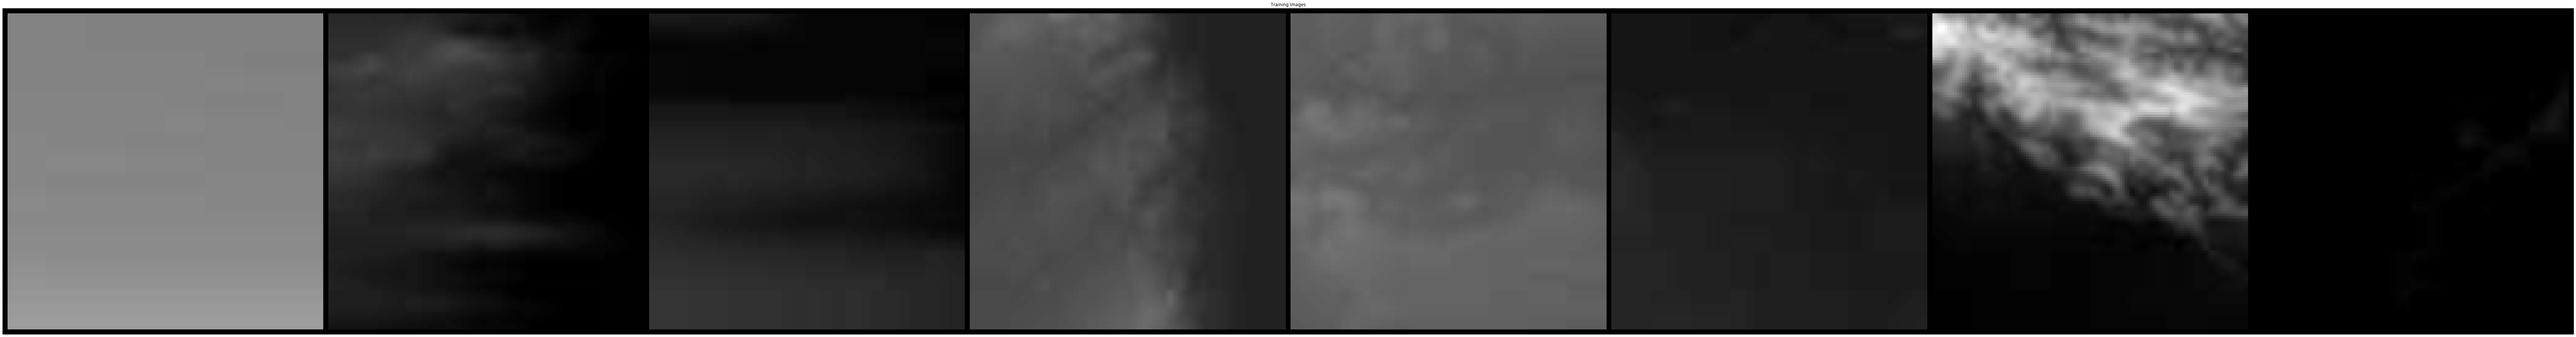

In [6]:
plt.figure(figsize=(128,128))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, npgu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.init_size = 128 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

#from torchsummary import summary
#summary(netG, input_size= (100, 1024, 4))

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=131072, bias=True)
  )
  (conv_blocks): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)


Discriminator Code



In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 128 // 2 ** 4
        self.adv_layer = nn.Linear(128 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

#from torchsummary import summary
#summary(netD, input_size = (3, 128, 128))

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [12]:
# Initialize BCELoss function
#criterion = nn.BCELoss()
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)
print(fixed_noise.shape)
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

torch.Size([128, 100, 1, 1])


In [13]:
from torch.autograd import Variable


In [19]:
Tensor = torch.cuda.FloatTensor
img_list = []
G_losses = []
D_losses = []
iters = 0
# ----------
#  Training
# ----------

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizerG.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = netG(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = 0.5*criterion(netD(gen_imgs), valid)

        g_loss.backward()
        optimizerG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizerD.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(netD(real_imgs), valid)
        fake_loss = criterion(netD(gen_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizerD.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     d_loss.item(), g_loss.item()))
        
        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        batches_done = epoch * len(dataloader) + i
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == 50-1) and (i == len(dataloader)-1)):
            #with torch.no_grad():
                #fake = netG(fixed_noise).detach().cpu()
            #img_list.append(vutils.make_grid(fake, padding=0, normalize=True))
            save_image(gen_imgs.data[:25], "lsganimages/%d.png" % batches_done, nrow=5, normalize=True)
        iters += 1

[0/1][0/1514]	Loss_D: 0.2392	Loss_G: 0.1167
[0/1][50/1514]	Loss_D: 0.2373	Loss_G: 0.1306
[0/1][100/1514]	Loss_D: 0.2153	Loss_G: 0.1510
[0/1][150/1514]	Loss_D: 0.2509	Loss_G: 0.1282
[0/1][200/1514]	Loss_D: 0.2488	Loss_G: 0.1245
[0/1][250/1514]	Loss_D: 0.2661	Loss_G: 0.1222
[0/1][300/1514]	Loss_D: 0.2550	Loss_G: 0.1342
[0/1][350/1514]	Loss_D: 0.2439	Loss_G: 0.1196
[0/1][400/1514]	Loss_D: 0.2531	Loss_G: 0.1211
[0/1][450/1514]	Loss_D: 0.2112	Loss_G: 0.1299
[0/1][500/1514]	Loss_D: 0.2508	Loss_G: 0.1075
[0/1][550/1514]	Loss_D: 0.2505	Loss_G: 0.1246
[0/1][600/1514]	Loss_D: 0.2362	Loss_G: 0.1293
[0/1][650/1514]	Loss_D: 0.2546	Loss_G: 0.1283
[0/1][700/1514]	Loss_D: 0.2524	Loss_G: 0.1158
[0/1][750/1514]	Loss_D: 0.2437	Loss_G: 0.1169
[0/1][800/1514]	Loss_D: 0.2464	Loss_G: 0.1158
[0/1][850/1514]	Loss_D: 0.2521	Loss_G: 0.1361
[0/1][900/1514]	Loss_D: 0.2362	Loss_G: 0.1093
[0/1][950/1514]	Loss_D: 0.2760	Loss_G: 0.1056
[0/1][1000/1514]	Loss_D: 0.2671	Loss_G: 0.1338
[0/1][1050/1514]	Loss_D: 0.2489	Loss

In [ ]:
torch.save(netG.state_dict(), directoryName+"/%dnetGModel" % batches_done)

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




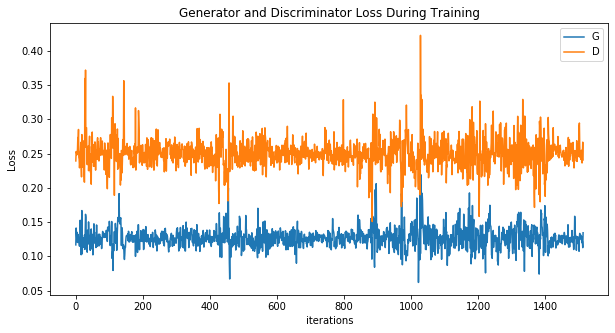

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [21]:
print(type(img_list[0]))
print(img_list[0].shape)
for i in range(len(img_list)):
    img_list[i]=img_list[i].detach().cpu()

IndexError: list index out of range

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Where to Go Next
----------------

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>`__




In [ ]:
print(len(img_list[0]))
#print(img_list[0])
print(img_list[0].shape)

#f=open('FakeImage.txt','w')
from torchvision.utils import save_image

for idx, item in enumerate(img_list):
    save_image(item, 'FakeImageFolder2/img'+str(idx)+'.png')

#f.close()